In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from itertools import product
from tqdm import notebook

In [2]:
df = pd.read_csv('res_pctchange_sincos_moneysupply.csv')
# could still add money supply to this

In [3]:
# The 'date' column is replaced with two columns for the sin and cos transformation in order to capture 
# the cyclical nature of the years of the month and thereby the sin and cos columns are representative of 
# seasonality effects (in a sense, although seasonality effects are also captured by the hyperparameters in a SARIMA
# or SARIMAX model)

df = df.drop(columns=['Date'])
Cpi_Can = df['CPICan']
sin = df['Year sin']
cos = df['Year cos']
df = df.drop(columns=['CPICan', 'Year sin','Year cos'])

# Here I'm doing a time shift for all the exogenous variables so that we can predict CPI using data from 12 months
# Before the preidction period. 
df = df.shift(periods=12)
df['CPICan'] = Cpi_Can
df['sin'] = sin
df['cos'] = cos

df = df[12:]
df = df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])

In [4]:
# These are a collection of variables that showed up as more important features across models when conducting a 
# a comparative analysis of different models for preidcting CPI. 
# the comparative analysis showed SARIMAX and SARIMA to be the best performing models so now I'm revisiting the 
# SARIMAX model and trying to see if I can imporve by taking out some of the less important features and hopefully
# this will avoid some overfitting problems

df = df[[
 'CommMetalMineral',
 'CommAgriculture',
 'CommForestry',
 'FarmOilseeds',
 'FarmPotato',
 'FarmHogs',
 'FarmPoultry',
 'FarmEggs',
 'FarmMilk',
 'IndustryLumberWood',
 'IndustryPulpPaper',
 'IndustryFabMetConstruction',
 'IndustryMachinery',
 'IndustryFurnitureFixture',
 'IntlImportForestryBuildingPackaging',
 'IntlImportMachineryEquipment',
 'IntlImportElectronicElectric',
 'IntlImportMotorVehicle',
 'IntlImportAircraftTransport',
 'IntlExportForestryBuildingPackaging',
 'IntlExportMachineryEquipment',
 'IntlExportElectronicElectric',
 'IntlExportMotorVehicle',
 'IntlExportAircraftTransport',
 'RawMatCrude',
 'RawMatCrop',
 'RawMatAnimal',
 'RawMatNonMetMin',
 'M1+',
 'M2++',
 'CPICan',
 'sin',
 'cos']]

In [5]:
test = df[491-12:492] # test
validate = df[491-12-12:491-12] # validate
train = df[:491-12-12] # train

# train+valid for final model
f_train = df[:491-12]

In [6]:
FEATURES = train.drop(columns=['CPICan']).columns
TARGET = 'CPICan'

In [7]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_valid = validate[FEATURES]
y_valid = validate[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

y_f_train = f_train[TARGET]
X_f_train = f_train[FEATURES]

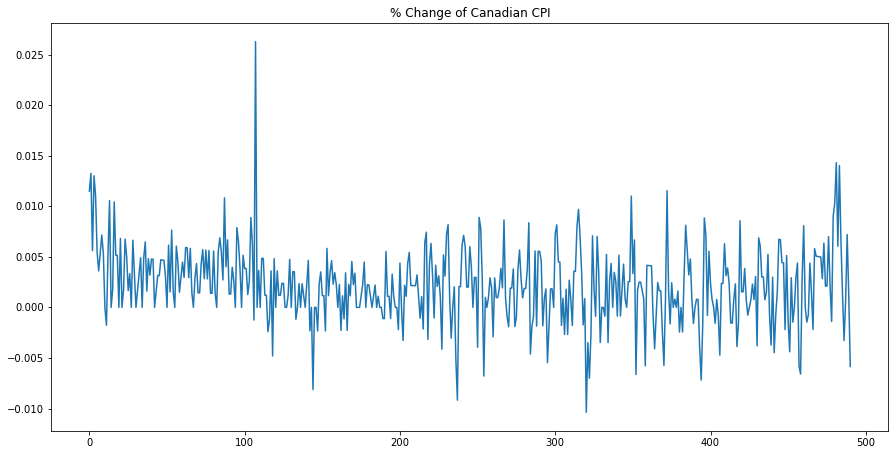

In [8]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df['CPICan'])
plt.title("% Change of Canadian CPI")
plt.show()

In [9]:
ad_fuller_result = adfuller(df['CPICan'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')  # Checking that the data is stationary after the % change transformation

ADF Statistic: -3.9420265713856706
p-value: 0.001746427286561684


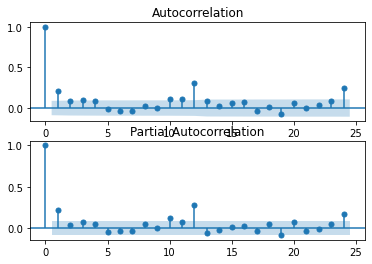

In [10]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(df['CPICan'], lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['CPICan'], lags=24, ax=ax[1])
plt.show()

# checking AC and Partial AC to see what might be good hyperparameters for SARIMAX

In [11]:
p = 1 # positive spikes
d = 0 # number of times differencing the data in order to make it stationary
q = 0 # negative spikes
P = 1 # positive spikes
D = 0 # number of times differencing the data in order to make it stationary
Q = 0 # negative spikes
s = 12 # seasonality (12 months, 1 year)

Optimization terminated successfully.
         Current function value: -4.319506
         Iterations: 3
         Function evaluations: 996


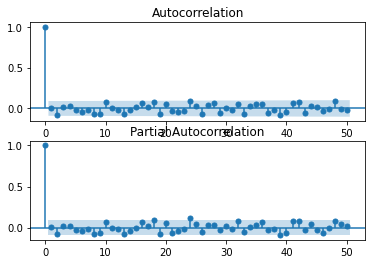

In [12]:
model = sm.tsa.statespace.SARIMAX(y_train, exog = X_train, order = (p,d,q), seasonal_order = (P,D,Q,s)).fit(max_iter=50, method='powell')

res = model.resid

fig, ax = plt.subplots(2,1)

fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

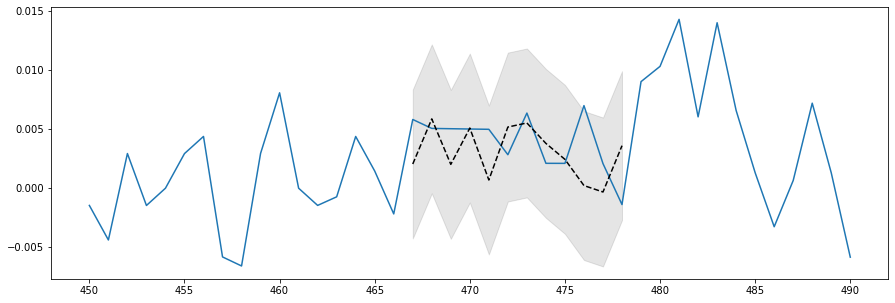

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
df['CPICan'].loc[450:].plot(ax=ax)

# Construct the forecasts
fcast = model.get_forecast(steps = 12, exog = X_valid).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);



In [14]:
rmse(y_valid, fcast['mean'])

0.003268779800960916

In [15]:
#set parameter range for a grid search that makes theoretical sense based on the implications of the hyperparameters
p = [1,3]
d = [0,1]
q = [0,1]
P = [0,1]
D = [0,1]
Q = [0,2]
s = [12]

combo = list(itertools.product(p,d,q,P,D,Q,s))


params_list = []
rmse_list =[]


# this for loop creates a model trained on the training set and evaluates RMSE for a forecast over the validation
# period and stores the hyperparameters associated with a given RMSE
for x in range(len(combo)):
    mod = sm.tsa.statespace.SARIMAX(y_train, exog = X_train,
                                    order=combo[x][0:3],
                                    seasonal_order=combo[x][3:])
    results = mod.fit(max_iter = 50, method = 'powell')
    fcast = results.get_forecast(steps = 12, exog = X_valid).summary_frame()
    rtmnsqer = rmse(y_valid, fcast['mean'])
    params_list += [combo[x]]
    rmse_list += [rtmnsqer]
    

Optimization terminated successfully.
         Current function value: -4.305153
         Iterations: 1
         Function evaluations: 318
Optimization terminated successfully.
         Current function value: -4.322651
         Iterations: 3
         Function evaluations: 1032
Optimization terminated successfully.
         Current function value: -4.003156
         Iterations: 1
         Function evaluations: 338
Optimization terminated successfully.
         Current function value: -4.200482
         Iterations: 4
         Function evaluations: 1456
Optimization terminated successfully.
         Current function value: -4.319506
         Iterations: 3
         Function evaluations: 996
Optimization terminated successfully.
         Current function value: -4.327477
         Iterations: 4
         Function evaluations: 1423
Optimization terminated successfully.
         Current function value: -4.103252
         Iterations: 5
         Function evaluations: 1758
Optimization terminated

Optimization terminated successfully.
         Current function value: -4.185518
         Iterations: 23
         Function evaluations: 9847
Optimization terminated successfully.
         Current function value: -4.312296
         Iterations: 16
         Function evaluations: 6099
Optimization terminated successfully.
         Current function value: -4.325893
         Iterations: 13
         Function evaluations: 5219
Optimization terminated successfully.
         Current function value: -4.085037
         Iterations: 25
         Function evaluations: 10095
Optimization terminated successfully.
         Current function value: -4.180331
         Iterations: 21
         Function evaluations: 9202


In [16]:
param_rmse_df = pd.DataFrame()
param_rmse_df['params'] = params_list
param_rmse_df['rmse'] = rmse_list
param_rmse_df

,params,rmse
0,"(1, 0, 0, 0, 0, 0, 12)",0.003468
1,"(1, 0, 0, 0, 0, 2, 12)",0.003242
2,"(1, 0, 0, 0, 1, 0, 12)",0.004804
3,"(1, 0, 0, 0, 1, 2, 12)",0.002937
4,"(1, 0, 0, 1, 0, 0, 12)",0.003269
...,...,...
59,"(3, 1, 1, 0, 1, 2, 12)",0.003208
60,"(3, 1, 1, 1, 0, 0, 12)",0.003535
61,"(3, 1, 1, 1, 0, 2, 12)",0.003249
62,"(3, 1, 1, 1, 1, 0, 12)",0.003433


In [17]:
param_rmse_df.sort_values('rmse').head(5)

,params,rmse
55,"(3, 1, 0, 1, 1, 2, 12)",0.002400
51,"(3, 1, 0, 0, 1, 2, 12)",0.002423
23,"(1, 1, 0, 1, 1, 2, 12)",0.002732
15,"(1, 0, 1, 1, 1, 2, 12)",0.002866
7,"(1, 0, 0, 1, 1, 2, 12)",0.002874


Optimization terminated successfully.
         Current function value: -4.108788
         Iterations: 6
         Function evaluations: 2450
RMSE: 0.004231303874271946


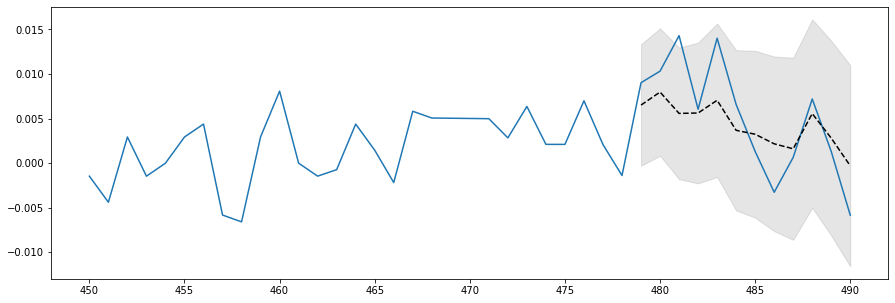

In [19]:
# Based on the grid search the best hyperparameters are:
p = 3
d = 1
q = 0
P = 1
D = 1
Q = 2
s = 12 

# build model with these hyperparameters
model = sm.tsa.statespace.SARIMAX(y_f_train, exog = X_f_train, order = (p,d,q), seasonal_order = (P,D,Q,s)).fit(max_iter=50, method='powell')

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
df['CPICan'].loc[450:].plot(ax=ax)

# Construct the forecasts
fcast = model.get_forecast(steps = 12, exog=X_test).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

print(f"RMSE: {rmse(y_test, fcast['mean'])}")

Just a note that this outperforms SARIMA which ended up with an RMSE of > 0.0046 